In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pyccl

In [2]:
cosmo = pyccl.core.Cosmology(Omega_c=0.206, Omega_b=0.044, h=0.7, n_s=0.95, sigma8=0.8, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, m_nu=0.0, m_nu_type=None, w0=-1.0, wa=0.0, T_CMB=None)

In [3]:
mascara = hp.read_map("/afs/ciemat.es/user/d/davfer/public/mascara_map.fits", verbose=False)
pix_ocupados = np.where(mascara == 1)[0]
T = hp.read_map("/scratch/davfer/Cosmohub/Mollview_T_HI_0_5_0_6_disp_catalogo_completo_jupyter.fits", field=0, verbose=False)
T_mean = np.mean(T[pix_ocupados])
Delta_T = T - T_mean

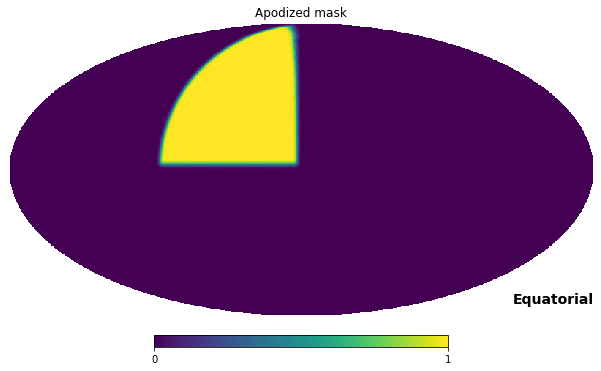

In [4]:
# Import the NaMaster python wrapper
import pymaster as nmt

#  Simple example showcasing the use of NaMaster to compute the pseudo-Cl
#  estimator of the angular cross-power spectrum of a spin-0 field and a
#  spin-2 field

# HEALPix resolution parameter used here
nside = 256
npix = hp.nside2npix(nside)

# Read mask and apodize it on a scale of ~1deg
mask = nmt.mask_apodization(mascara, 1., apotype="Smooth")
hp.mollview(mask, coord=['C'], title='Apodized mask')
plt.show()

# Read healpix maps and initialize a spin-0 and spin-2 field
f_0 = nmt.NmtField(mask, [Delta_T])
#f_2 = nmt.NmtField(mask, hp.read_map("/afs/ciemat.es/user/d/davfer/public/Mollview_T_HI_0_5_0_6_catalogo_completo_jupyter.fits", field=[1, 2], verbose=False))

# Initialize binning scheme with 20 ells per bandpower
b = nmt.NmtBin.from_nside_linear(nside, 20)
ell_arr = b.get_effective_ells()
i_primeros_puntos = np.where(ell_arr < 400)[0]
#ell_arr_primeros_puntos = ell_arr[i_primeros_puntos] 
delta_ell_arr = ell_arr[1:]-ell_arr[:-1]
delta_ell_arr = np.append(delta_ell_arr,delta_ell_arr[-1])
#delta_ell_arr_primeros_puntos = ell_arr_primeros_puntos[1:]-ell_arr_primeros_puntos[:-1]
#delta_ell_arr_primeros_puntos = np.append(delta_ell_arr_primeros_puntos,delta_ell_arr_primeros_puntos[-1])
# Compute MASTER estimator
# spin-0 x spin-0
cl_00 = nmt.compute_full_master(f_0, f_0, b)
# spin-0 x spin-2
#cl_02 = nmt.compute_full_master(f_0, f_2, b)
# spin-2 x spin-2
#cl_22 = nmt.compute_full_master(f_2, f_2, b)

#Teorico (pyccl)
z = np.loadtxt('/scratch/davfer/Cosmohub/z_array_0_5_0_6_disp.txt')
N_z = np.loadtxt('/scratch/davfer/Cosmohub/z_hist_0_5_0_6_disp.txt')
dndz = (z,N_z)
ell = np.linspace(1,800,100)

bias_valores = np.arange(0.5,2.01,0.01)
Chi_2 = []

for i in range(len(bias_valores)):
    bias = (z,np.full(len(z),bias_valores[i]))
    has_rsd = False
    cltracer1 = pyccl.tracers.NumberCountsTracer(cosmo, has_rsd, dndz, bias, mag_bias=None)
    cltracer2 = cltracer1
    limber_integration_method = 'qag_quad'
    l_limber = -1.0
    p_of_k_a = None
    cl = pyccl.cls.angular_cl(cosmo, cltracer1, cltracer2, ell_arr, p_of_k_a, l_limber)*T_mean**2
    chi_2 = sum((cl_00[0][i_primeros_puntos]-bias_valores[i]*cl[i_primeros_puntos])**2*(2*ell_arr[i_primeros_puntos]+1)*delta_ell_arr[i_primeros_puntos]*(1/8)/(2*cl_00[0][i_primeros_puntos]**2))
    Chi_2.append(chi_2)
Chi_2 = np.array(Chi_2)
i_optimo = np.where(Chi_2 == min(Chi_2))[0]
bias_optimo = bias_valores[i_optimo]
bias = (z,np.full(len(z),bias_optimo))
has_rsd = False
cltracer1 = pyccl.tracers.NumberCountsTracer(cosmo, has_rsd, dndz, bias, mag_bias=None)
cltracer2 = cltracer1
limber_integration_method = 'qag_quad'
l_limber = -1.0
p_of_k_a = None
cl_ell_arr = pyccl.cls.angular_cl(cosmo, cltracer1, cltracer2, ell_arr, p_of_k_a, l_limber)*T_mean**2
Var = 2*cl_ell_arr**2/((1/8)*(2*ell_arr+1)*delta_ell_arr)
Sigma = np.sqrt(Var)
cl = pyccl.cls.angular_cl(cosmo, cltracer1, cltracer2, ell, p_of_k_a, l_limber)*T_mean**2

In [5]:
#Ahora mismo está restringida a l < lmax = 400 porque la Chi_2_fun se definió así
Likelihood_no_norm = np.exp(-Chi_2/2)
Norm = 1/(np.sum(Likelihood_no_norm*0.01))
Likelihood = Norm*Likelihood_no_norm
Mean = np.sum(Likelihood*bias_valores*0.01)
Varianza_bias = np.sum(Likelihood*(bias_valores-Mean)**2*0.01)
Error_bias = np.sqrt(Varianza_bias)

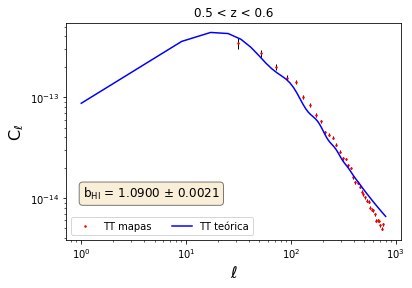

In [6]:
cl_datos = cl_00[0][1:]
ell_datos =  ell_arr[1:]
Sigma_datos = Sigma[1:]

params = {'mathtext.default': 'regular' }          
# Plot results
plt.plot(ell_datos, cl_datos, 'r.', markersize=3, label='TT mapas')
plt.plot(ell,cl,'b-',label='TT teórica')
plt.errorbar(ell_datos, cl_datos, yerr=Sigma_datos, fmt='None', ecolor='k',elinewidth=1)
#plt.plot(ell_arr, np.fabs(cl_02[0]), 'g-', label='TE')
#plt.plot(ell_arr, cl_22[0], 'b-', label='EE')
#plt.plot(ell_arr, cl_22[3], 'y-', label='BB')
plt.loglog()
plt.xlabel('$\\ell$', fontsize=16)
plt.ylabel('$C_\\ell$', fontsize=16)
plt.legend(loc='best', ncol=2, labelspacing=0.1)
plt.title('0.5 < z < 0.6')
plt.rcParams.update(params)
ax = plt.gca()
textstr = r'$b_{{HI}}$ = {:.4f} $\pm$ {:.4f}'.format(bias_optimo[0],Error_bias)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
plt.text(0.05, 0.25, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.savefig('../Plots/Correlacion_T_HI_0_5_0_6_disp_catalogo_completo.png',dpi=900)
plt.show()